This notebook uses the `tynt` package, available for download with:

    pip install git+https://github.com/bmorris3/tynt

In [2]:
import json

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.modeling.models import BlackBody
from astropy.table import Table

In [3]:
n_wavelengths = 10_000
wavelength = np.logspace(-1, 1, n_wavelengths) * u.um
nu = wavelength.to(u.GHz, u.spectral())[::-1]

In [4]:
# built-in filter names:
filter_names = [
    "SLOAN/SDSS.u", "Generic/Stromgren.v", "Generic/Johnson.B", 
    "CHEOPS/CHEOPS.band", "GAIA/GAIA2.G", 
    "Kepler/Kepler.K", "TESS/TESS.Red"
]

In [5]:
from tynt import FilterGenerator, Filter

f = FilterGenerator()

In [6]:
from tqdm.auto import tqdm

plot_filters = dict()
filters = dict()
for filt_name in tqdm(f.available_filters()):
    filt = f.download_true_transmittance(filt_name, cache=True)
    if filt_name in filter_names:
        plot_filters[filt_name] = filt
    filters[filt_name] = filt

  0%|          | 0/1140 [00:00<?, ?it/s]

In [17]:
# SOHO VIRGO filter profile described here: 
# https://adsabs.harvard.edu/full/1995ASPC...76..408A
wl_soho = wavelength.copy()
# The SOHO VIRGO PMO6 radiometer measures *bolometric* fluxes:
tr_soho = np.ones_like(wl_soho.value)

filters['SOHO VIRGO'] = Filter(wl_soho, tr_soho)

In [18]:
# JWST/NIRSpec filter profile:
wl_nirspec, tr_nirspec = np.loadtxt('../data/NIRSpec_S1600_prism_clear_throughput.csv', unpack=True, delimiter=',')

filters['NIRSpec/Prism'] = Filter(wl_nirspec*u.um, tr_nirspec)

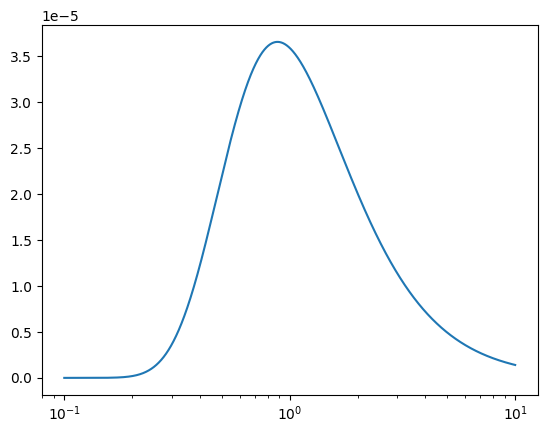

SLOAN/SDSS.u amplitude is 4.3733069598x SOHO


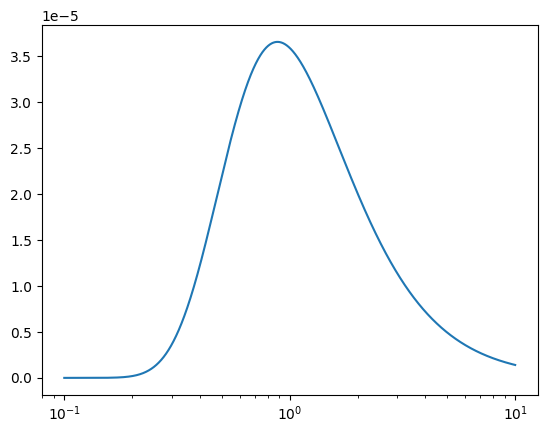

Generic/Stromgren.v amplitude is 3.8315714481x SOHO


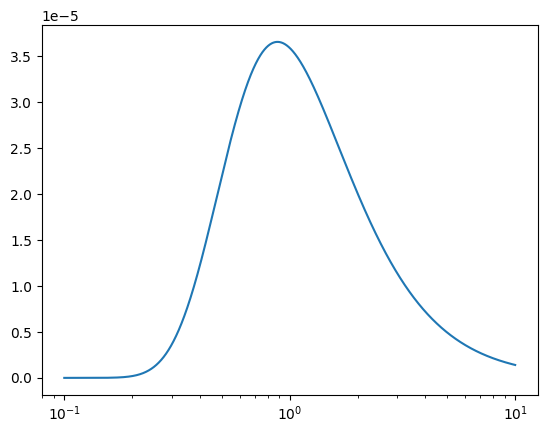

Generic/Johnson.B amplitude is 3.5070890305x SOHO


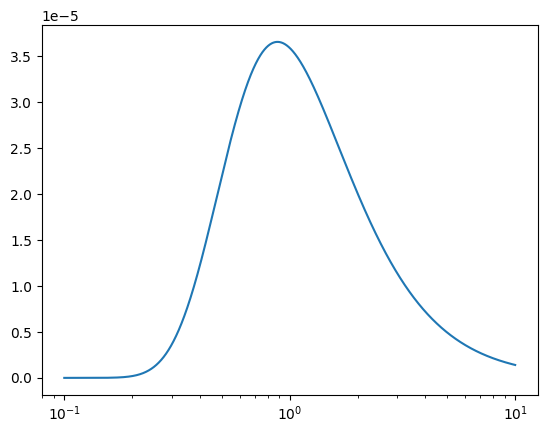

CHEOPS/CHEOPS.band amplitude is 2.4040186627x SOHO


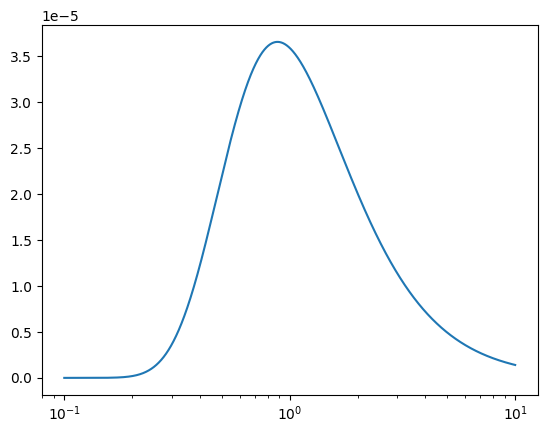

GAIA/GAIA2.G amplitude is 2.3109856387x SOHO


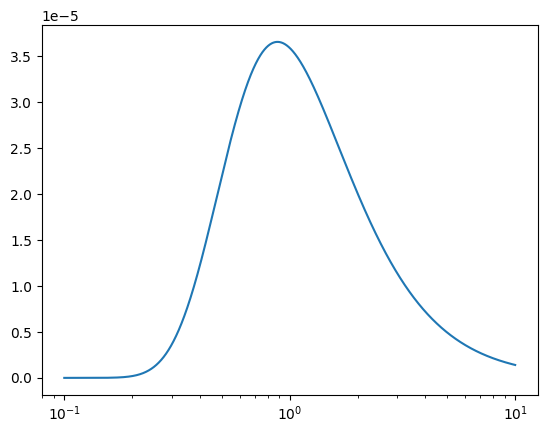

Kepler/Kepler.K amplitude is 2.4324605258x SOHO


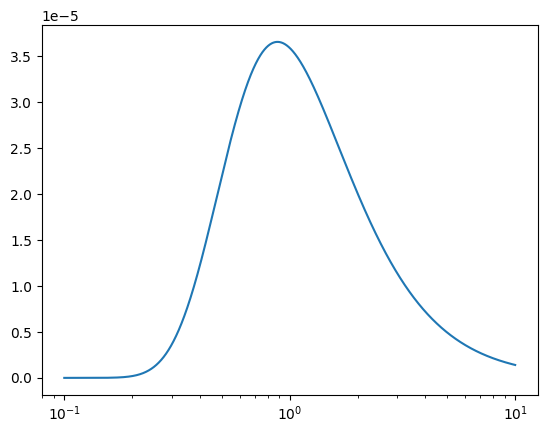

TESS/TESS.Red amplitude is 2.0565126699x SOHO


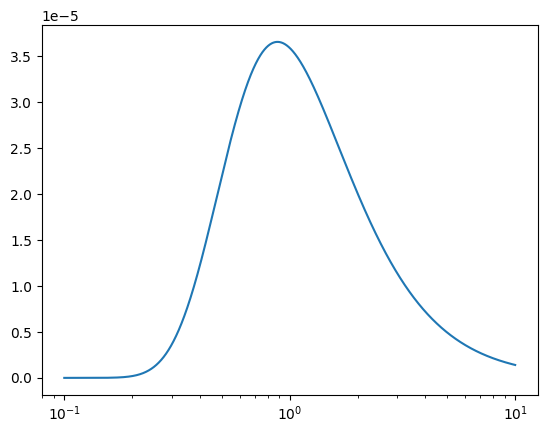

NIRSpec/Prism amplitude is 1.0538031859x SOHO


In [29]:
def compare_filters(filter_names, T_S=5777 * u.K, nu=nu, wavelength=wavelength):
    # assert filter_names[0] == 'SOHO VIRGO'
    # Morris 2020, eqn 11:
    dT = np.atleast_2d([-10, 10]).T * u.K
    temperatures = dT + T_S

    I_nu = BlackBody(T_S)(wavelength)
    dI_dT = np.diff(BlackBody(temperatures)(wavelength), axis=0)[0] / dT.ptp()
    
    f0, f1 = filter_names
    filt0_transmittance = np.interp(
        wavelength.to(u.um).value, filters[f0].wavelength.to(u.um).value, filters[f0].transmittance, left=0, right=0
    )
    # filt0_transmittance = filt0_transmittance / np.trapz(filt0_transmittance, wavelength)
    filt1_transmittance = np.interp(
        wavelength.to(u.um).value, filters[f1].wavelength.to(u.um).value, filters[f1].transmittance, left=0, right=0
    )
    # filt1_transmittance = filt1_transmittance / np.trapz(filt1_transmittance, wavelength.to(u.um).value)
    ratio_0 = (
        np.trapz(dI_dT * wavelength.to(u.um) * filt1_transmittance, wavelength.to(u.um)) /
        np.trapz(dI_dT * wavelength.to(u.um) * filt0_transmittance, wavelength.to(u.um))
    )
    ratio_1 = (
        np.trapz(I_nu * wavelength.to(u.um) * filt0_transmittance, wavelength.to(u.um)) / 
        np.trapz(I_nu * wavelength.to(u.um) * filt1_transmittance, wavelength.to(u.um))
    )
    
    # plt.semilogx(wavelength, filt0_transmittance)
    # plt.plot(wavelength, filt1_transmittance)
    plt.semilogx(wavelength, I_nu)
    plt.show()
    return (ratio_0 * ratio_1).decompose()

for other in filter_names + ['NIRSpec/Prism']:
    alpha = compare_filters(['SOHO VIRGO', other]).value
    print(f"{other} amplitude is {alpha:.10f}x SOHO")

In [ ]:
print("Variability ratio, compare X with Kepler:")
for other in filter_names + ['NIRSpec/Prism']:
    alpha = compare_filters(['Kepler/Kepler.K', other]).value
    print(f"{other} / Kepler = {alpha:.10f}")

In [ ]:
# Simple sanity check:
assert compare_filters(['SOHO VIRGO', 'SOHO VIRGO']) == 1

In [ ]:
from tqdm.auto import tqdm

In [ ]:
temperatures = np.arange(2000, 6500, 100)
plot_filters = filter_names + ['NIRSpec/Prism']

alpha = np.zeros((len(temperatures), len(filters))) # plot_filters
i = -1
for T_S in tqdm(temperatures):
    i += 1
    for j, other in enumerate(filters): # plot_filters
        alpha[i, j] = compare_filters(['SOHO VIRGO', other], T_S * u.K).value

In [ ]:
alpha_kepler = np.zeros((len(temperatures), len(plot_filters)))
i = -1
for T_S in tqdm(temperatures):
    i += 1
    for j, other in enumerate(plot_filters):
        alpha_kepler[i, j] = compare_filters(['Kepler/Kepler.K', other], T_S * u.K).value

Fit with a simple parameterization:

In [ ]:
plt.plot(temperatures, alpha, alpha=0.5)
bounds = [[None, None], [0, None], [None, None]]

# labels = [pf.split('/')[0] 
#           if not (
#               pf.split('/')[0].startswith("Generic") or
#               pf.split('/')[0].startswith("SLOAN")) 
#           else pf.split('/')[1].replace('.', ' ')
#           for pf in filters] # plot_filters
labels = [pf for pf in filters] # plot_filters

rows = []
for i, filt in enumerate(labels):
    model = lambda p: p[0] * np.exp(p[1] * (2000 - temperatures) / 1000) + p[2]
    chi2 = lambda p: np.sum((model(p) - alpha[:, i])**2)
    result = minimize(chi2, [1, 0.1, -1.5], method='l-bfgs-b', bounds=bounds) 
    
    if result.success:
        rows.append([filt] + result.x.tolist())
        plt.plot(temperatures, model(result.x), color=f'C{i}', ls='--')

results_table = Table(rows=rows, names="Filter $c_0$ $c_1$ $c_2$".split())

formats = len(result.x) * ['%.2f']
for col, fmt in zip(results_table.colnames[1:], formats):
    results_table[col].format = fmt
results_table.write('tables/estimate_alpha_tynt.tex', format='latex', overwrite=True)

Write out the results to a JSON file: 

In [ ]:
results_pandas = results_table.to_pandas(index='Filter').transpose()

json.dump(
    json.loads(results_pandas.to_json()), 
    open('tables/estimate_alpha_tynt.json', 'w'), 
    indent=4
)

In [ ]:
lam_mean = np.ones((len(plot_filters)))

for i, filt in enumerate(plot_filters):
    lam_mean[i] = ((
        np.trapz(filters[filt].wavelength.to(u.um).value * filters[filt].transmittance, filters[filt].wavelength.to(u.um).value) / 
        np.trapz(filters[filt].transmittance, filters[filt].wavelength.to(u.um).value)
    ) * u.um).to(u.nm).value

In [ ]:
sort = np.argsort(lam_mean)
plot_filters = np.array(plot_filters)[sort]

labels_with_wavelengths = [
    f"{lam_mean[sort][:-1][i]:.0f} nm ({{\\footnotesize {lab.split('/')[1].replace('.', ' ')}}})" 
    # if last part of bandpass name is "Band" or something longer:
    if '.' in lab and len(lab.split('/')[1].split('.')[1]) == 1 else
    f"{lam_mean[sort][:-1][i]:.0f} nm ({{\\footnotesize {lab.split('/')[1].split('.')[0]}}})"
    for i, lab in enumerate(plot_filters[:-1])
]

In [ ]:
labels_with_wavelengths += [f"{lam_mean[-1]/1000:.1f} $\\mathrm{{\\mu}}$m ({{\\footnotesize {plot_filters[-1].split('/')[1].split('.')[0]}}})".replace('Prism', 'NIRSpec/Prism')]

In [ ]:
plt.rc('text', usetex=True)

def cmap(lam):
    log_min = np.log(400)
    log_max = np.log(900)
    x = (np.log(lam) - log_min) / (log_max - log_min)
    return plt.cm.Spectral_r(x)

fig, ax = plt.subplots(2, 1, figsize=(6, 6))
plot_filt_no_kep = [[pf, pf_wl, lamb, pf.startswith("Kepler")] 
                    for pf, pf_wl, lamb in zip(plot_filters, labels_with_wavelengths, lam_mean)]

for label, label_wl, lam, toggle in plot_filt_no_kep:
    alpha_i = alpha[:, label==np.array(list(filters.keys()))]
    alpha_kepler_i = alpha_kepler[:, label==np.array(list(plot_filters))]
    ax[0].semilogy(temperatures, alpha_i, label=label_wl, color=cmap(lam))
    if not toggle:
        ax[1].plot(temperatures, alpha_kepler_i, label=label_wl, color=cmap(lam))

ax[0].legend(title="Variability at $\\bar{{\\lambda}}$ relative to\n{\\bf SOHO VIRGO/PMO6}:", loc=(1.01, 0.15), alignment='left')
ax[1].legend(title="Variability at $\\bar{{\\lambda}}$ relative to {\\bf Kepler}:", loc=(1.01, 0.15), alignment='left')
for axis in ax:
    for sp in ['right', 'top']:
        axis.spines[sp].set_visible(False)


fontsize = 14
for axis in ax:
    axis.set_xlabel(axis.get_xlabel(), fontsize=fontsize)
    axis.set_ylabel(axis.get_ylabel(), fontsize=fontsize)
    axis.set(
        xlabel=r'$T_{\rm eff}$ [K]',
        ylabel=r'$\alpha$'
    )
fig.tight_layout()

fig.savefig('plots/alpha.pdf', bbox_inches='tight')